### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot variables distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from hist.intervals import ratio_uncertainty
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector

/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
# load the slimmedtree files using uproot

# different year available here.
#year = "2016"
year = "2017"
# year = "2018"
#year = "Full-Run2"

# if run on PKU cluster, use this:
CustNanoData = {
    'data'        : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/Data/SlimmedTree_Data.root"   % (year),
    'QCD'         : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_QCD.root"   % (year),
    'TT'          : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_TT.root"     % (year),
    'ST'          : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_ST.root"     % (year),
    'WJets'       : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_WJets.root" % (year),
    'Rest'        : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_Rest.root"  % (year),
    'Signal'      : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_Signal.root" % (year),
}

files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

In [3]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/plots/30May2014"
_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
for typefile in files:
    print('%-16s' % typefile, '%10d' % len(files[typefile]), sep='\t')

data            	  41845929
QCD             	  31399695
TT              	   6682512
ST              	    624027
WJets           	   7092794
Rest            	   4016334
Signal          	      6115


### Define taggers

In [5]:
def add_tagger(events):
    events["probQCD"] = ak.zeros_like(events["a_Hbc"])
    qcd_list = [
    "a_QCDbb",
    "a_QCDcc",
    "a_QCDb",
    "a_QCDc",
    "a_QCDothers",
    ]
    for score in qcd_list:
        events["probQCD"] = events["probQCD"] + events[score]
    events["HbcVSQCS"] = (events["a_Hbc"])/(events["a_Hbc"] + 0.997032*events["probQCD"] + 0.002968*events["a_Hcs"])
for k in files:
    print("Add tagger of:",k)
    add_tagger(events=files[k])

Add tagger of: data


Add tagger of: QCD
Add tagger of: TT
Add tagger of: ST
Add tagger of: WJets
Add tagger of: Rest
Add tagger of: Signal


In [6]:
files["W"] = files["Signal"][files["Signal"]["w_a"] == 1]
files["g/q"] = files["Signal"][files["Signal"]["gKK_g_a"] == 1]
files["rest"] = files["Signal"][(files["Signal"]["gKK_g_a"] != 1) & (files["Signal"]["w_a"] != 1)]

In [7]:
print(len(files["W"]))
print(len(files["g/q"]))
print(len(files["rest"]))

3398
2408
309


### output all the variables for which we can make plots

In [8]:
files["Signal"].fields

['Etaj',
 'Etaj_2',
 'Etaj_3',
 'Etaj_V2_a',
 'Etaj_V2_b',
 'Etaj_V2_c',
 'Etaj_max',
 'Etaj_mid',
 'Etaj_min',
 'HT',
 'LHEScaleWeight_0',
 'LHEScaleWeight_1',
 'LHEScaleWeight_2',
 'LHEScaleWeight_3',
 'LHEScaleWeight_4',
 'LHEScaleWeight_5',
 'LHEScaleWeight_6',
 'LHEScaleWeight_7',
 'LHEScaleWeight_8',
 'MET_et',
 'MET_et_UEdown',
 'MET_et_UEup',
 'MET_phi',
 'MET_phi_UEdown',
 'MET_phi_UEup',
 'MJJ',
 'MJJJ',
 'Mj',
 'Mj_2',
 'Mj_3',
 'Mj_V2_a',
 'Mj_V2_b',
 'Mj_V2_c',
 'Mj_corr_V2_a',
 'Mj_corr_V2_b',
 'Mj_corr_V2_c',
 'Mj_jerDown_a',
 'Mj_jerDown_b',
 'Mj_jerDown_c',
 'Mj_jerUp_a',
 'Mj_jerUp_b',
 'Mj_jerUp_c',
 'Mj_jesAbsoluteDown_a',
 'Mj_jesAbsoluteDown_b',
 'Mj_jesAbsoluteDown_c',
 'Mj_jesAbsoluteUp_a',
 'Mj_jesAbsoluteUp_b',
 'Mj_jesAbsoluteUp_c',
 'Mj_jesAbsolute_yearDown_a',
 'Mj_jesAbsolute_yearDown_b',
 'Mj_jesAbsolute_yearDown_c',
 'Mj_jesAbsolute_yearUp_a',
 'Mj_jesAbsolute_yearUp_b',
 'Mj_jesAbsolute_yearUp_c',
 'Mj_jesBBEC1Down_a',
 'Mj_jesBBEC1Down_b',
 'Mj_jesBBEC

### plot setting, error setting, histogram setting

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define main plots function

In [10]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def makeplots(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', nbins=20, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/nbins
    #blind data in this region
    if blind:
        mask = np.logical_or(arrays["data"] <= 50, arrays["data"] >= 110)
        arrays["data"] = arrays["data"][mask]
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT","ST","WJets","Rest"]
    name_dict_sig = {
        #sig
        "Signal":"TotalSig",
        "ggF"        :'ggF',
        "ttH"        :"ttH",
        "VBF"        :"VBF",
        "WH"         :"WH",
        "ZH"         :"ZH",
    }
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'Signal': 'black'}
    SIG_DECO_COLOR = {'Signal': 'black',"W":"blue","g/q":"pink","rest":"gray"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","TT","ST","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        print(bkg_h)
        bkg_err = np.sum(err_list ,  axis=0)
        print(bkg_err)
        bin_edges = np.linspace(x_min, x_max, nbins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Stat. Unc.",
        }
        ax.stairs(values = bkg_h - bkg_err[0], baseline = bkg_h + bkg_err[1], edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["Signal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=False, stack=False, ax=ax)
            
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
            print(data_mc_ratio)
            
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            print(ratio_error)
            
            # now first directly scale the data error with `data/MC` ratio
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            
            
            # then add shaded error to ratio plot
            errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 1,
            "alpha": 0.4,
            "label":"Stat. Unc."
            }
            
            ax1.stairs(values = 1 - bkg_err[0]/bkg_h, baseline = 1 + bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
        
        else:  # signal
            if deco != True: #plot signal in different production mode
                if k in ["Signal"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_COLOR[k])
            
            else: #plot signal in signal decomposition mode
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["Signal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "Signal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            
            if k == "Signal": #print optimal cut information
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                # best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                # print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2)
        ax1.set_ylim(0.3, 1.8)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=12)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

### define the cut for each regions, for examples, SRs, CRs, PS and MET regions here:

In [11]:
CUT = {        
    "SR1" : {k:  (files[k]["nb_t_deep_ex"] == 0) & (files[k]["HbcVSQCS"] >= 0.995) for k in files}, 
    "SR2" : {k:  (files[k]["nb_t_deep_ex"] == 0) & (files[k]["HbcVSQCS"] >= 0.95) & (files[k]["HbcVSQCS"] <= 0.995) for k in files}, 
    "SR3" : {k:  (files[k]["nb_t_deep_ex"] == 0) & (files[k]["HbcVSQCS"] >= 0.9) & (files[k]["HbcVSQCS"] <= 0.95) for k in files}, 
    "CR"  : {k:  (files[k]["nb_t_deep_ex"] == 0) & (files[k]["HbcVSQCS"] < 0.9)  for k in files},   
    "PS"  : {k:  (files[k]["nb_t_deep_ex"] >= 0)  for k in files}, 
  
    }

# CR: tagger < 0.9

### define the variables we want to plot

In [12]:
def run_makeplots(region = "PS", events = files, nametext = "", blind = False, othertext = "", deco = False, optimal_cut = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}  # weight for each event
    makeplots(arrays = {k: events[k][CUT[region][k]]["Mj_corr_V2_a"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='jetmass', x_name=r'$jet_{a}$:soft-drop jet mass', x_max=230, x_min=30, nbins=20, weight =weight, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    makeplots(arrays = {k: events[k][CUT[region][k]]["PTj_V2_a"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='pT', x_name=r'$jet_{a}$:jet pT', x_max=800, x_min=200, nbins=20, weight =weight, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    makeplots(arrays = {k: events[k][CUT[region][k]]["HbcVSQCS"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='Hbctagger', x_name=r'HbcVSQCS tagger:$jet_{a}$', x_max=1, x_min=0, nbins=40, weight =weight, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = True)
    # add the variables you want to plot here, like above.

### make plots for each region, some examples are shown here

[4580548.41738906 6629132.66121765 6581003.63872471 6495324.79099722
 6466575.18588141 6380117.74815177 6136527.14644574 5668314.50895859
 5098065.84495608 4482525.58766249 3858687.94944244 3233234.72316595
 2658721.2355414  2138362.33585755 1699185.71769315 1324824.93161603
 1014829.2745684   766142.48228325  574224.1119087   428719.65304821]
[[5835.2907563  7143.19796092 7203.22905777 7333.6421536  7468.30425768
  7502.54576659 7360.70336329 6991.69312724 6505.6881472  6013.71719176
  5467.76134045 4884.47156765 4314.70960024 3783.56998285 3276.63883813
  2817.30143828 2371.93246987 1971.83282015 1623.31919936 1320.53378534]
 [5835.2907563  7143.19796092 7203.22905777 7333.6421536  7468.30425768
  7502.54576659 7360.70336329 6991.69312724 6505.6881472  6013.71719176
  5467.76134045 4884.47156765 4314.70960024 3783.56998285 3276.63883813
  2817.30143828 2371.93246987 1971.83282015 1623.31919936 1320.53378534]]
Should scale signal *  149345.13083085406
0.5370309192568447
[[0.00141358 0

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


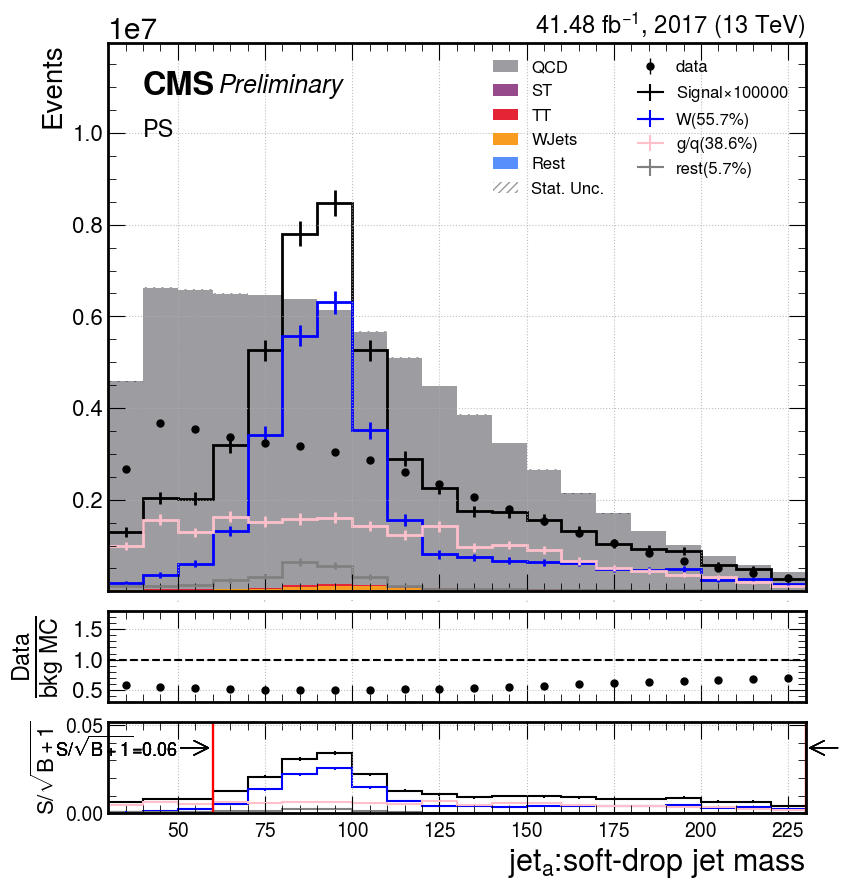

[  923814.08220506  1847822.96189985  3287238.9618671   4934154.72887824
  6455354.94149153  7942644.08122389 10059171.36328463 10199949.36760365
  8615378.69984997  6387030.04316425  4518929.78668889  3198561.02375168
  2306465.19936158  1674457.02164991  1228417.78457483   915165.85322661
   679971.65763884   513965.51970155   387810.70739931   295608.8761179 ]
[[2897.4983829  4401.17411139 6513.71762037 8418.87036636 9210.08642028
  8844.15119117 8736.37523343 8567.80185636 7903.34786374 6399.21921515
  4689.66452242 3282.472119   2416.07871573 1916.09773454 1586.79531942
  1331.25555772 1102.26225183  896.27118095  694.37087925  514.22499053]
 [2897.4983829  4401.17411139 6513.71762037 8418.87036636 9210.08642028
  8844.15119117 8736.37523343 8567.80185636 7903.34786374 6399.21921515
  4689.66452242 3282.472119   2416.07871573 1916.09773454 1586.79531942
  1331.25555772 1102.26225183  896.27118095  694.37087925  514.22499053]]
Should scale signal *  148877.93855132238
0.53769270100

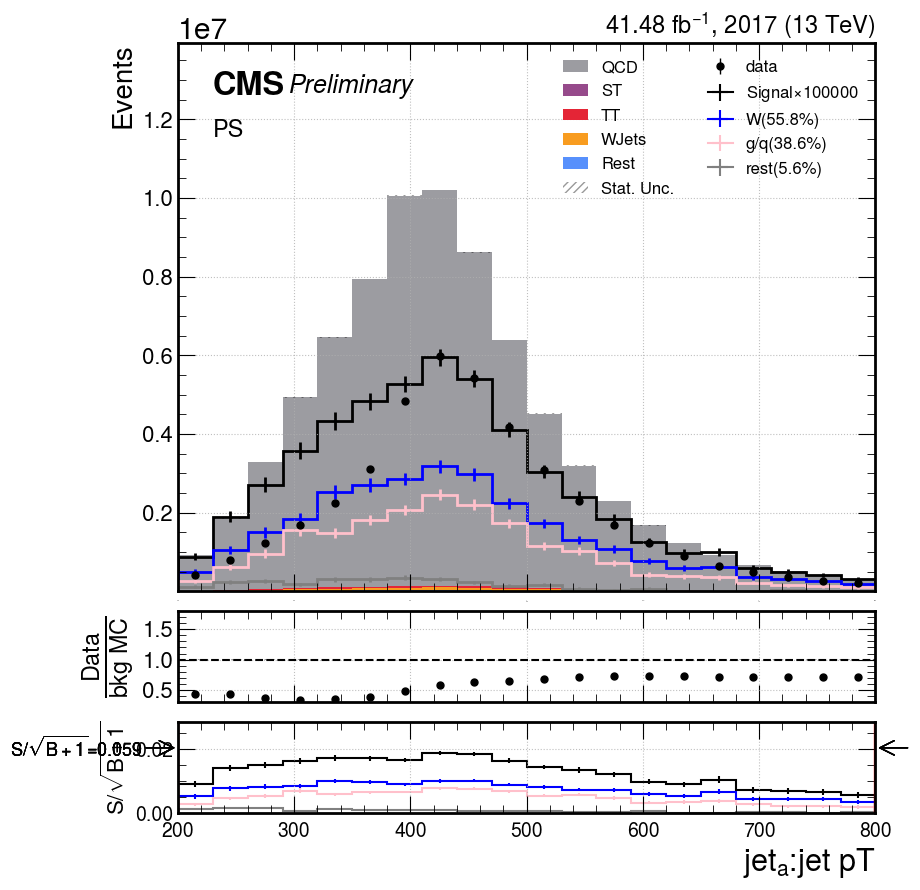

[58991393.45525789  4938404.37298235  2430474.07064247  1550002.66555032
  1118896.07148021   860934.66957472   696233.9906034    579501.34503187
   498825.19464743   434505.91432877   383564.38901115   348947.27613277
   317881.60523546   285307.01958245   265001.84161914   246824.21422573
   229374.08044306   216200.04713862   203509.44573956   191362.78535441
   180346.76503436   174268.02638794   166309.71420816   156410.7143559
   153413.72679513   147780.31585126   139983.88125174   135457.56334124
   132534.65118843   128474.59667401   125536.7311357    123586.18123697
   121487.47283536   119286.90121209   118313.47414641   116425.02696912
   118106.73931355   117673.44154265   120080.44873431   108918.33256061]
[[21488.74895107  6184.15098987  4341.24691449  3472.40597404
   2954.41369207  2573.85465439  2307.16955045  2103.79716571
   1957.10783514  1825.12784196  1725.96295004  1642.31551772
   1573.86194495  1476.83159355  1434.47952655  1377.61129155
   1337.08637258  1285

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


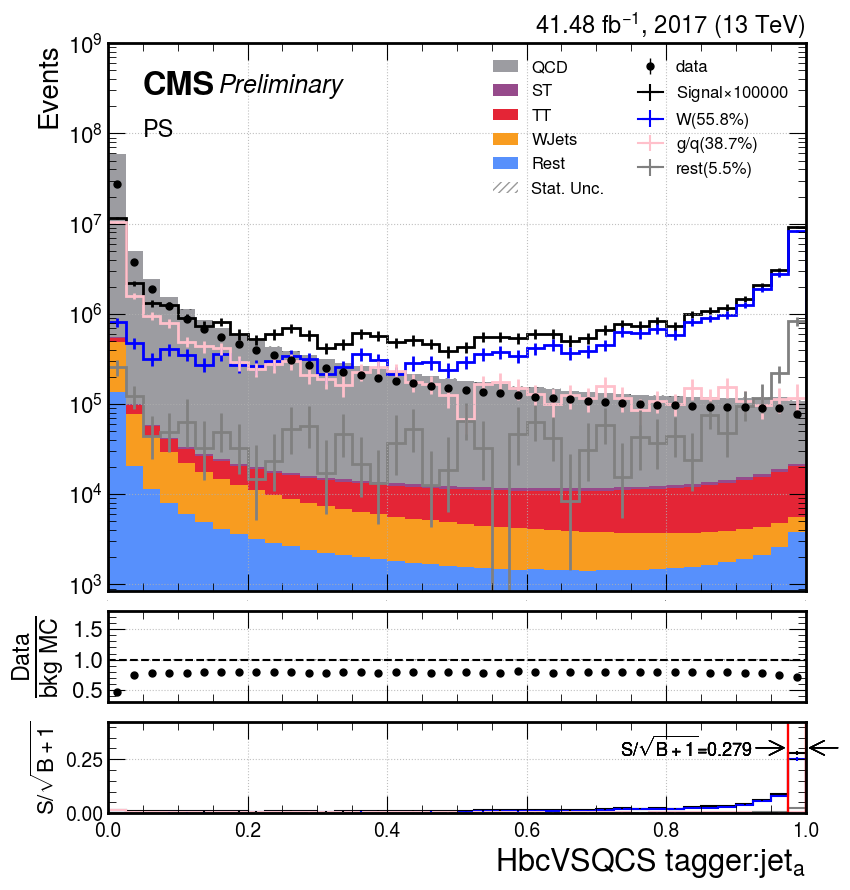

[1040.4551503  1353.68728486 1104.84472901 1304.25340836 1280.90721109
 1143.12849012 1178.37031543 1057.70458687  708.78409635  636.72294151
  562.3580069   598.53080462  527.01225962  451.48152109  336.42910047
  407.9990616   297.44516033  235.73271262  137.5909219   138.06296357]
[[ 81.4208711   95.80655618  90.05830238 103.25423509 110.40024761
   90.3291504   79.26635819  75.28361585  58.47062562  57.34979017
   52.64257298  54.87115799  50.90369069  43.81605866  32.28535218
   48.52287836  21.76739254  26.1854462   19.33339442  26.08628447]
 [ 81.4208711   95.80655618  90.05830238 103.25423509 110.40024761
   90.3291504   79.26635819  75.28361585  58.47062562  57.34979017
   52.64257298  54.87115799  50.90369069  43.81605866  32.28535218
   48.52287836  21.86223502  26.29050578  19.43056679  26.31736758]]
Should scale signal *  371.22988718139396
0.35099815501521686
[[0.08676605 0.07847584        nan        nan        nan        nan
         nan        nan 0.09233891 0.10158816 

/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/31

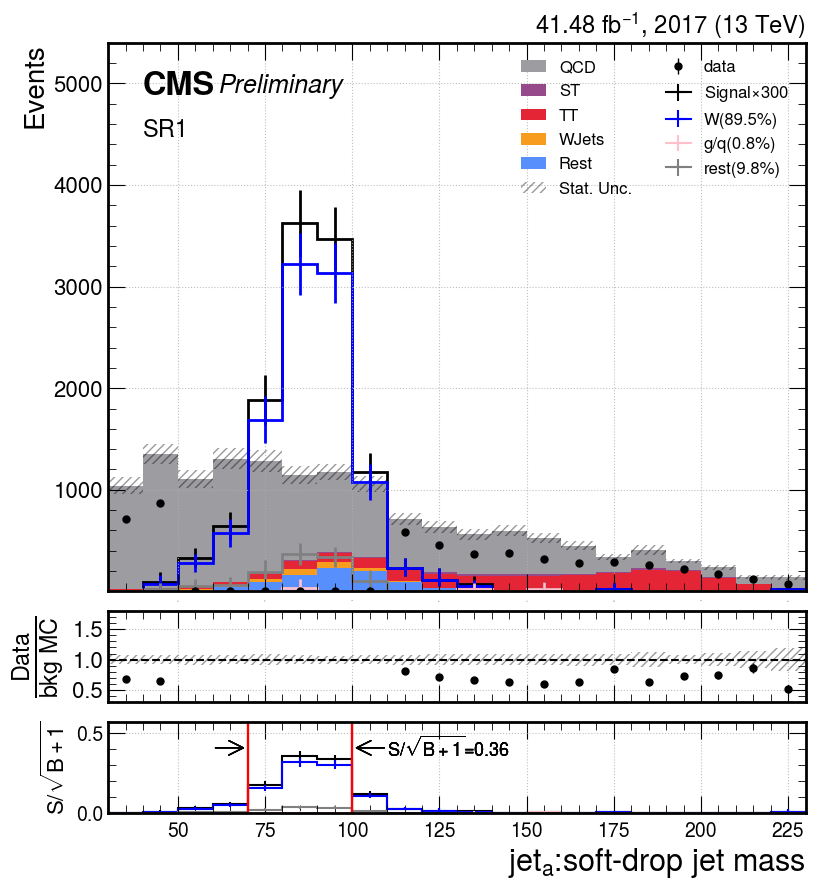

[  75.74119251  209.54235306  530.92372798 1024.5526874  1334.69582643
 1813.19514734 1906.67513099 1916.60884048 1600.46917731 1096.3469802
  826.50670015  585.65151255  441.30109767  329.63905553  239.4591077
  216.42632411  147.26504419  108.43443214   73.9138074    64.5114727 ]
[[ 20.0979325   37.04282959  73.87798453 111.282199   116.46015944
  114.32557715 111.94028027 103.87855837  96.51625332  73.99495854
   55.477583    40.65656152  32.71717561  26.42028338  21.22065977
   20.79636484  15.76655393  12.97864995   9.11967033   8.27786914]
 [ 20.26538153  37.04282959  73.87798453 111.282199   116.46015944
  114.32557715 111.94028027 103.87855837  96.51625332  73.99495854
   55.477583    40.65656152  32.71717561  26.42028338  21.22065977
   20.79636484  15.76655393  12.97864995   9.3463767    8.44783481]]
Should scale signal *  381.0618011121903
0.6803806569453023
[[0.30888618 0.20085309 0.15350692 0.11893159 0.09531102 0.07130359
  0.06518244 0.06003141 0.06669616 0.07470508 0.07

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


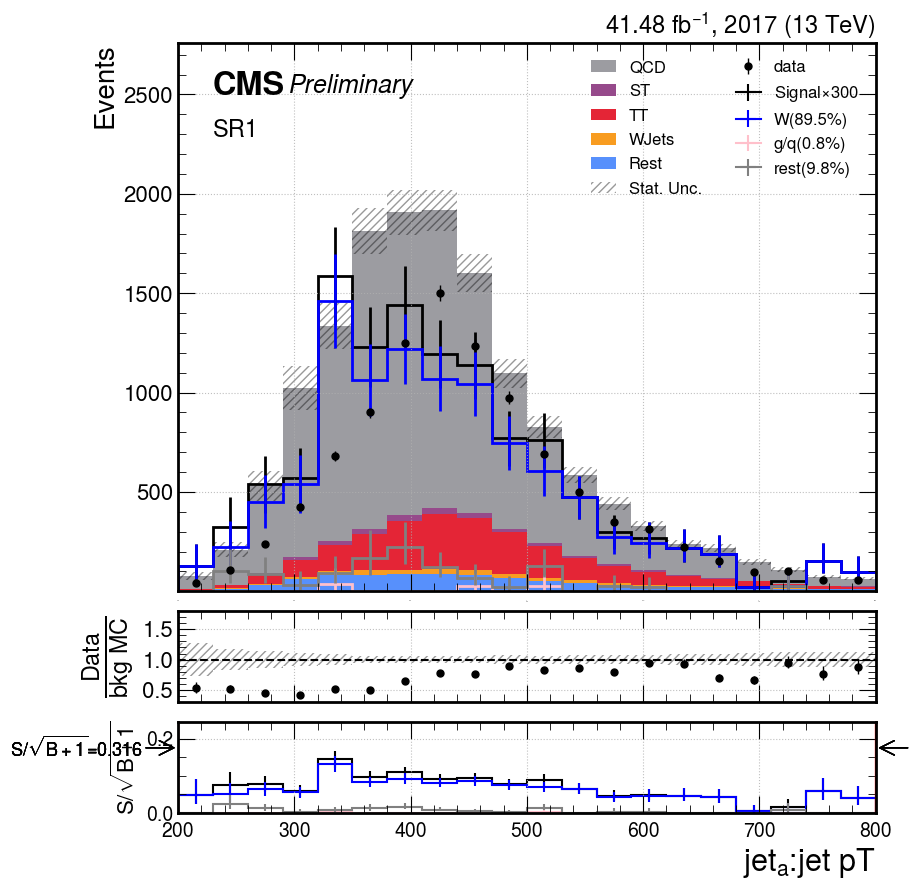

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/3618446447.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_1926826/3618446447.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 - bkg_err[0]/bkg_h, baseline = 1 + bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_1926

[    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.         14856.27051002]
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.   

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


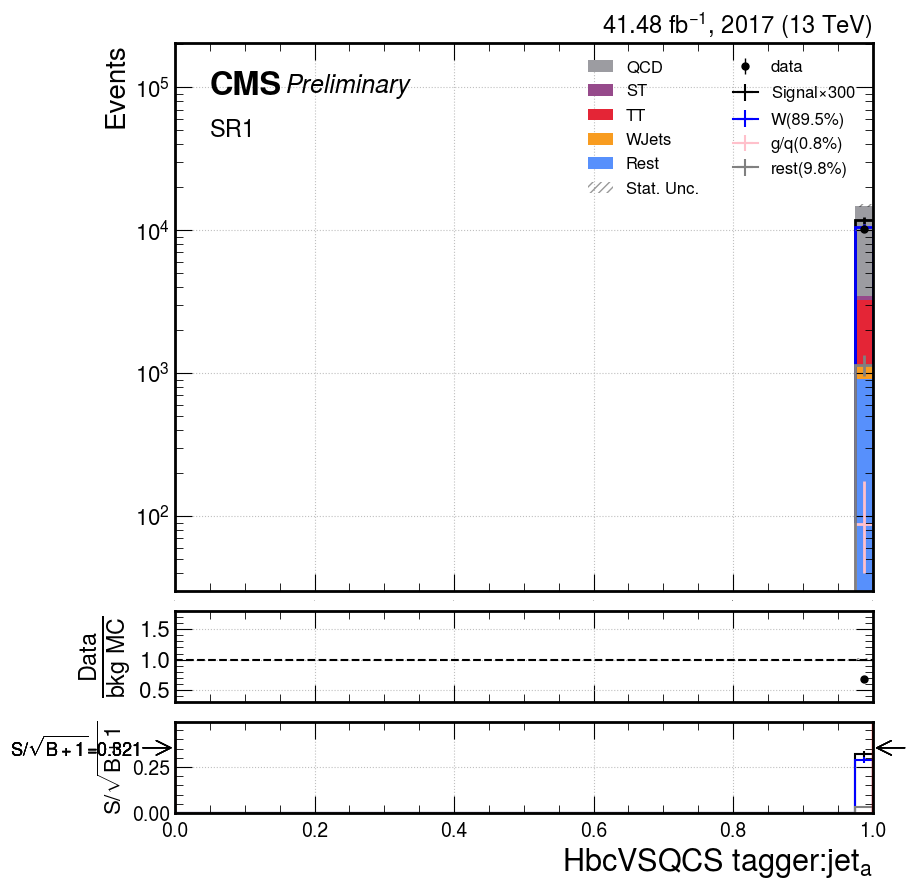

[10817.01876774 15150.71341906 14851.01657564 16341.69325337
 16274.81664271 16354.21499296 16152.8344895  14000.05400599
 12331.04748118  9757.73968139  9302.18840983  7778.85064636
  6670.68674491  5815.62956058  5247.73415917  4283.85180735
  3918.84090791  2945.11611849  1857.69255343  1426.70060753]
[[288.441012   353.5547711  342.7767593  364.65790828 364.36606954
  369.31567526 354.592316   326.63109572 310.86738902 254.36316457
  251.48666556 226.37745426 194.99682227 179.37056528 159.74897238
  127.59811348 121.64674989 104.65352682  76.39999727  69.03564375]
 [288.441012   353.5547711  342.7767593  364.65790828 364.36606954
  369.31567526 354.592316   326.63109572 310.86738902 254.36316457
  251.48666556 226.37745426 194.99682227 179.37056528 159.74897238
  127.59811348 121.64674989 104.65352682  76.39999727  69.03564375]]
Should scale signal *  2359.8839255171156
0.3927677352236912
[[0.02894129 0.02519553        nan        nan        nan        nan
         nan        nan 0.

/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/31

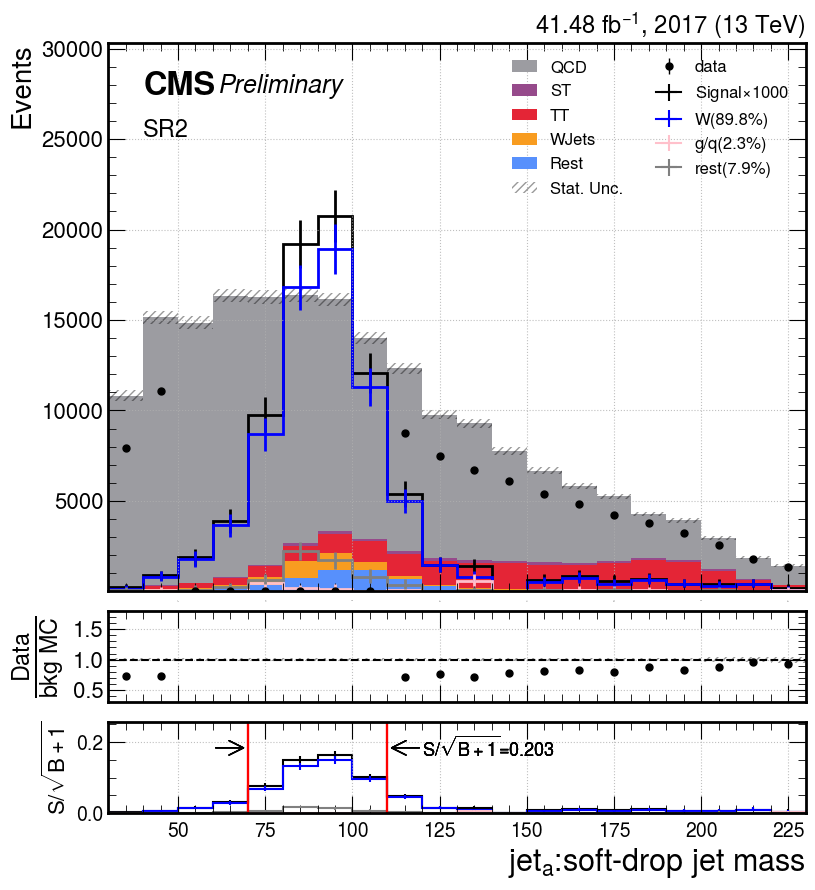

[  793.2309282   2714.41380872  7253.38474331 14636.17040921
 19510.02328806 22281.12185103 25841.81314996 24819.57532744
 20179.48005084 15767.194908   10414.94580501  7691.53694134
  5870.87342503  4064.65598557  3054.19820991  2304.54263357
  1837.7944311   1329.65431329  1034.28602521   764.3297833 ]
[[ 75.15476875 165.34749577 283.38661881 421.78017134 489.49083522
  444.71026959 418.11341199 408.7048748  366.80822066 305.66531808
  207.7041013  153.64587911 124.1694282   92.37800978  78.7226448
   66.25298206  57.66232198  45.42778279  36.69876924  26.53680754]
 [ 75.15476875 165.34749577 283.38661881 421.78017134 489.49083522
  444.71026959 418.11341199 408.7048748  366.80822066 305.66531808
  207.7041013  153.64587911 124.1694282   92.37800978  78.7226448
   66.25298206  57.66232198  45.42778279  36.69876924  26.53680754]]
Should scale signal *  2396.5912387081316
0.7393454145415845
[[0.10414317 0.06636681 0.04276257 0.03143424 0.02712532 0.0218225
  0.01782193 0.01787308 0.019

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


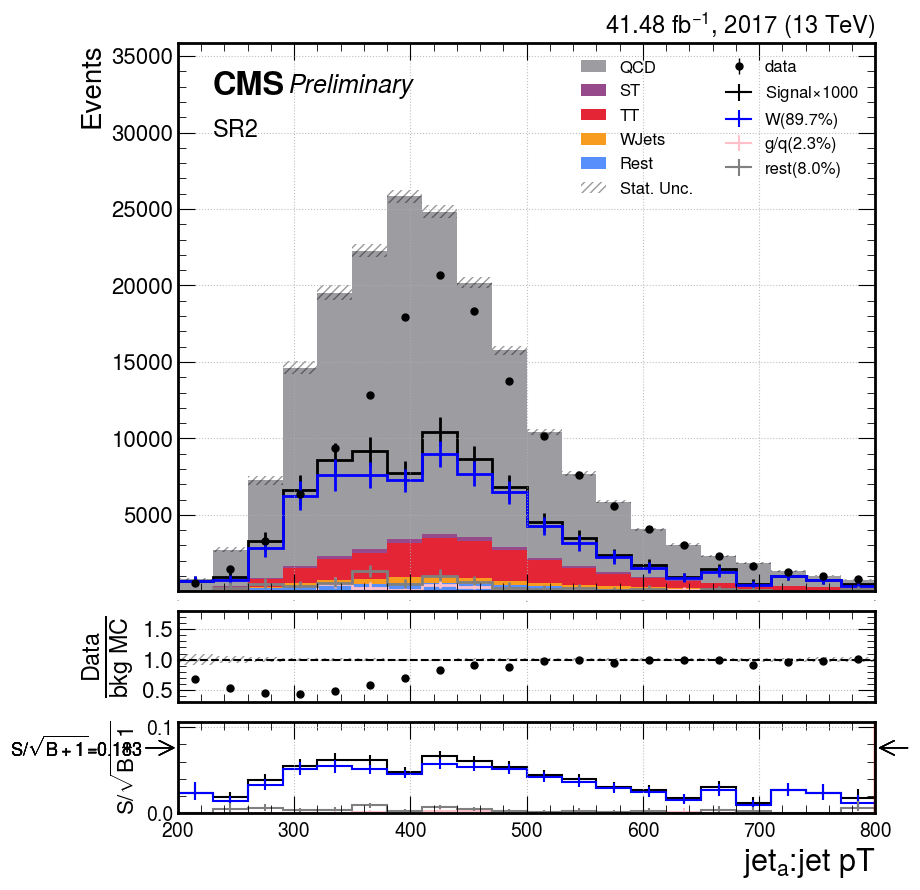

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/3618446447.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_1926826/3618446447.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 - bkg_err[0]/bkg_h, baseline = 1 + bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_1926

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83860871e+00 1.10413097e+05 8.49564713e+04]
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.   

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


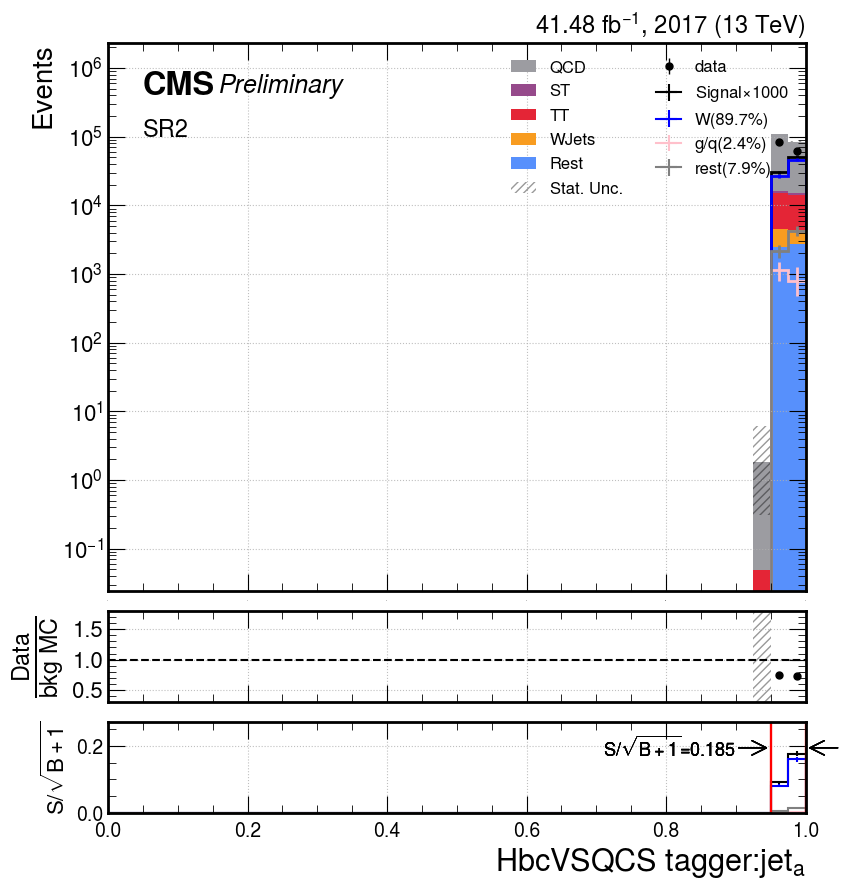

[10934.06008783 15838.0450799  16778.05962812 17723.08911732
 18055.94082894 19238.01869811 18084.01286074 15883.03986305
 13939.45412634 12047.66362313 10219.92371669  9290.47763983
  7527.11245086  6148.17030228  5590.1588398   4932.26514058
  4196.63955861  3126.80047484  2174.78626669  1583.755571  ]
[[289.63462108 352.48951916 368.81382064 402.69223521 384.09025544
  413.37235733 377.52915498 354.22555017 322.61353818 299.52236078
  260.72703326 243.73504897 212.96135882 172.96112381 165.933101
  159.09775593 138.58218983 108.42165101  87.19553882  77.68145436]
 [289.63462108 352.48951916 368.81382064 402.69223521 384.09025544
  413.37235733 377.52915498 354.22555017 322.61353818 299.52236078
  260.72703326 243.73504897 212.96135882 172.96112381 165.933101
  159.09775593 138.58218983 108.42165101  87.19553882  77.68145436]]
Should scale signal *  6236.690724473947
0.41599731316912
[[0.02860493 0.02395499        nan        nan        nan        nan
         nan        nan 0.0250788

/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/31

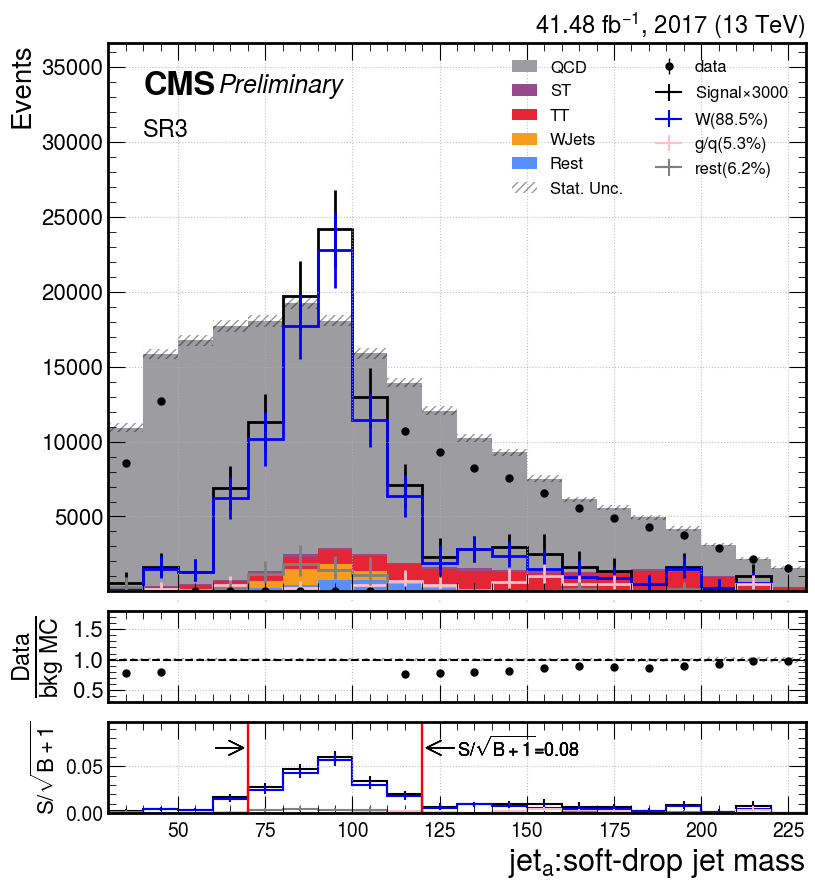

[  869.12592717  3083.10065305  8097.75326319 15770.44584723
 21916.16871357 25599.8517715  28520.22561746 27200.98732039
 22723.09642054 17402.92744627 12280.25995793  8783.46648342
  6353.67259248  4620.32275762  3389.19847851  2534.91623468
  1918.76139847  1477.17847473  1064.86823095   873.66579676]
[[ 77.53129408 176.10544733 313.52356029 446.46097945 517.73305214
  491.38629958 442.83664513 426.9128384  387.63721809 316.32725548
  238.71285013 169.33409812 127.69353243 101.71607022  84.46062069
   70.49511198  59.10358926  48.44970227  38.00341443  30.01654165]
 [ 77.53129408 176.10544733 313.52356029 446.46097945 517.73305214
  491.38629958 442.83664513 426.9128384  387.63721809 316.32725548
  238.71285013 169.33409812 127.69353243 101.71607022  84.46062069
   70.49511198  59.10358926  48.44970227  38.00341443  30.01654165]]
Should scale signal *  6364.994445448833
0.7770701470513912
[[0.09795091 0.06199762 0.04186233 0.0305714  0.02547394 0.0208999
  0.01698868 0.01693309 0.01

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


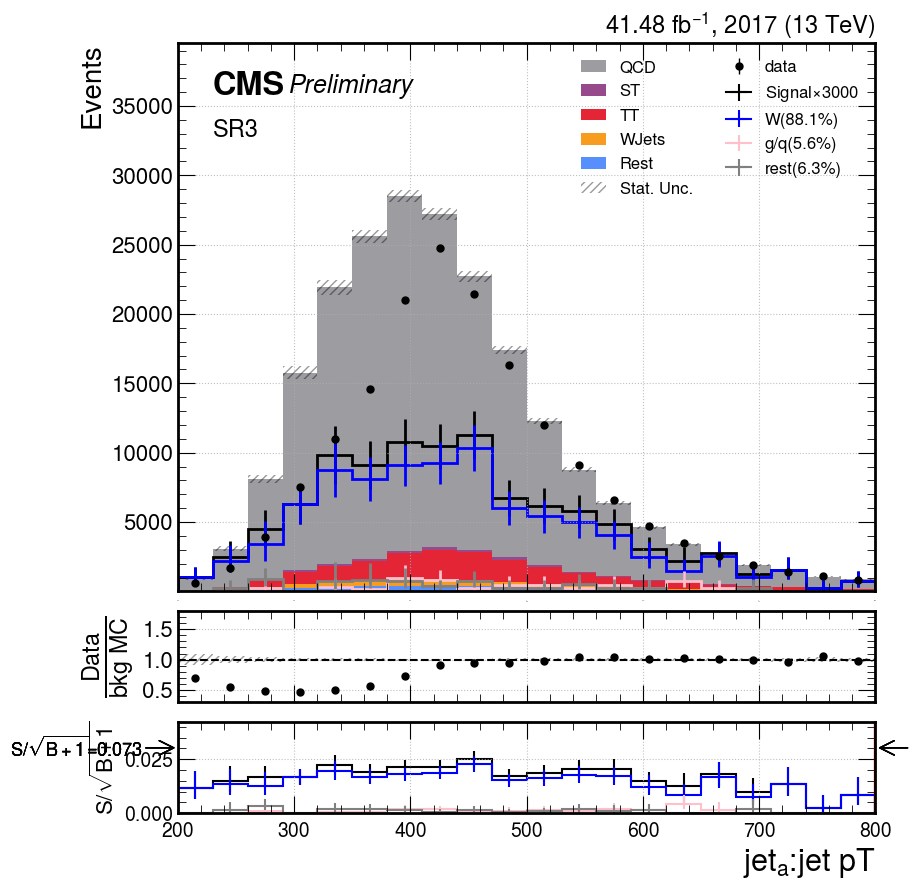

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/3618446447.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_1926826/3618446447.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 - bkg_err[0]/bkg_h, baseline = 1 + bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_1926

[     0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
 109294.34494947 108537.86577481      0.              0.        ]
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.  

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


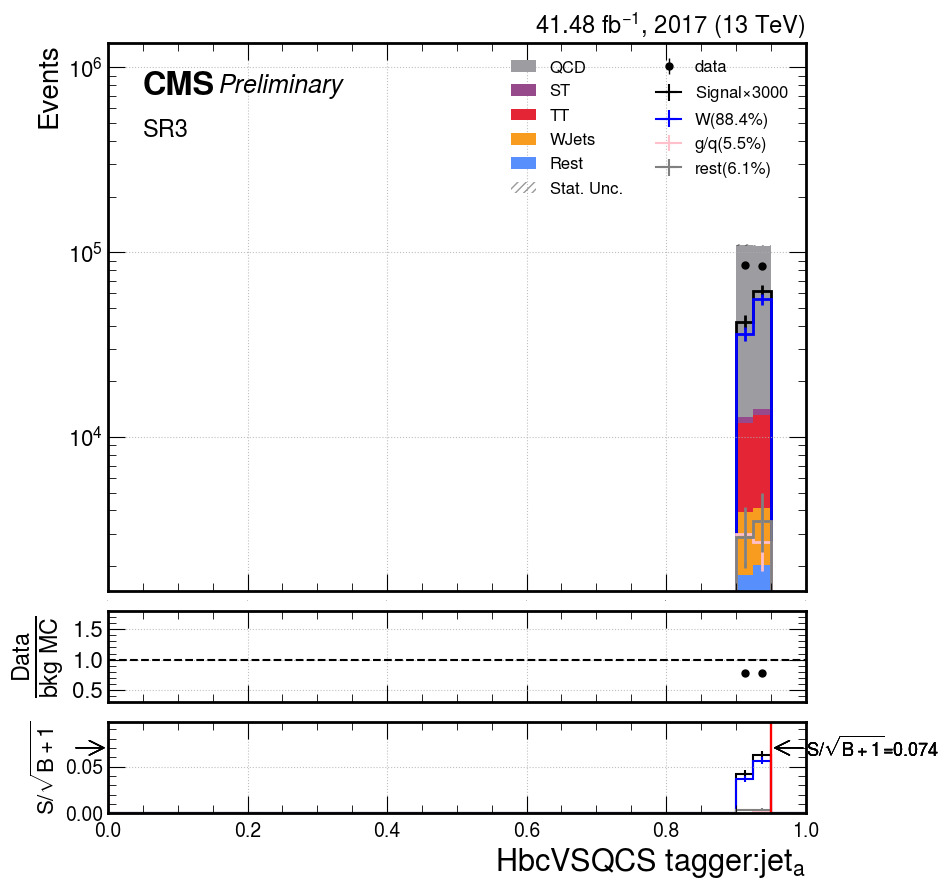

[4466982.60361675 6468687.52025946 6419837.2468381  6328849.01790529
 6295109.67312679 6204477.90898733 5967261.23526691 5516767.27183287
 4963819.71419082 4365003.44742924 3758266.75366796 3147239.22801514
 2587482.89694645 2080573.11370536 1650190.12668594 1284844.56104581
  982042.52354371  740630.93170933  556225.50071331  415467.32270861]
[[5762.94763251 7056.48014025 7114.49183803 7238.72392663 7367.73373799
  7396.39590967 7258.23668122 6898.50854482 6420.17143954 5934.45482811
  5398.42926218 4818.21249409 4256.37343213 3732.37782082 3230.39120766
  2775.5136143  2334.16794102 1938.83266038 1597.96235873 1298.86101751]
 [5762.94763251 7056.48014025 7114.49183803 7238.72392663 7367.73373799
  7396.39590967 7258.23668122 6898.50854482 6420.17143954 5934.45482811
  5398.42926218 4818.21249409 4256.37343213 3732.37782082 3230.39120766
  2775.5136143  2334.16794102 1938.83266038 1597.96235873 1298.86101751]]
Should scale signal *  243074.99546113773
0.5311706903714735
[[0.00143299 0

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


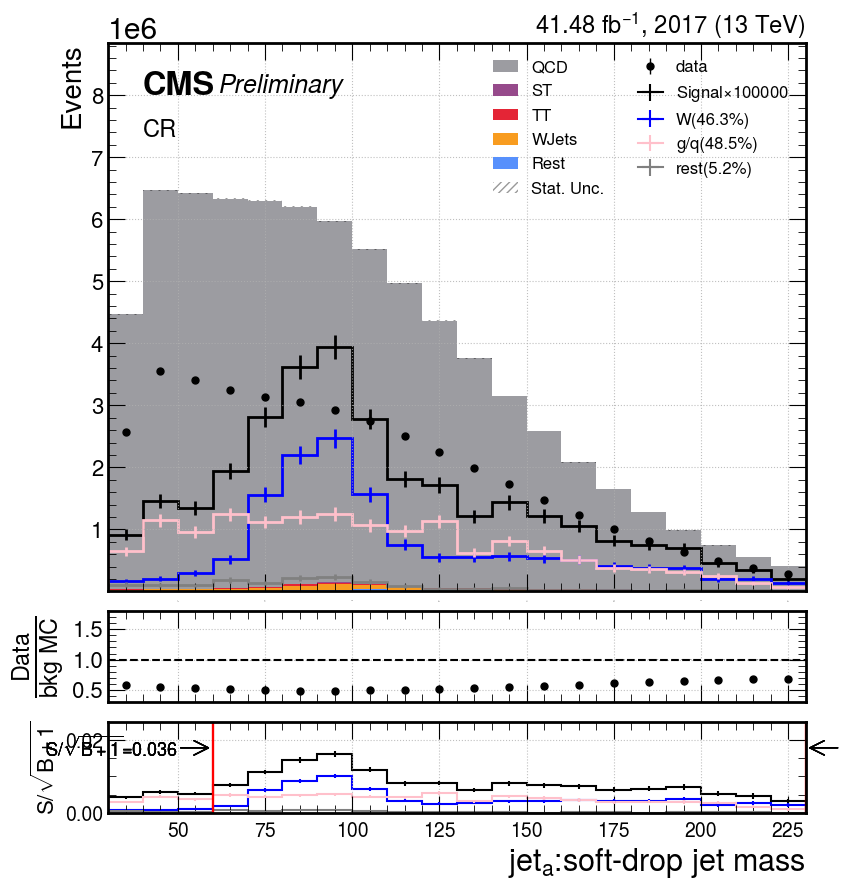

[ 883589.56168894 1772234.40734932 3162201.31291707 4760532.76452004
 6263765.73209252 7739441.22863406 9819548.48505951 9958108.68167102
 8411599.04737725 6233716.16985027 4410672.8272943  3121995.04748112
 2250460.17231913 1634143.28625221 1198655.90381185  893133.06926406
  663318.01159932  501559.36691458  378417.94249412  288437.1902786 ]
[[2831.09653738 4310.80826717 6400.46530749 8292.4388261  9091.62245813
  8739.03715059 8633.77665014 8463.45601178 7809.59720081 6322.53806959
  4632.8197194  3238.99184253 2380.72647473 1887.42023186 1562.78558981
  1311.87751846 1086.22492488  883.49512418  684.15154508  505.9907873 ]
 [2831.09653738 4310.80826717 6400.46530749 8292.4388261  9091.62245813
  8739.03715059 8633.77665014 8463.45601178 7809.59720081 6322.53806959
  4632.8197194  3238.99184253 2380.72647473 1887.42023186 1562.78558981
  1311.87751846 1086.22492488  883.49512418  684.15154508  505.9907873 ]]
Should scale signal *  239456.02884020715
0.5318057035698331
[[0.00358512 0

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


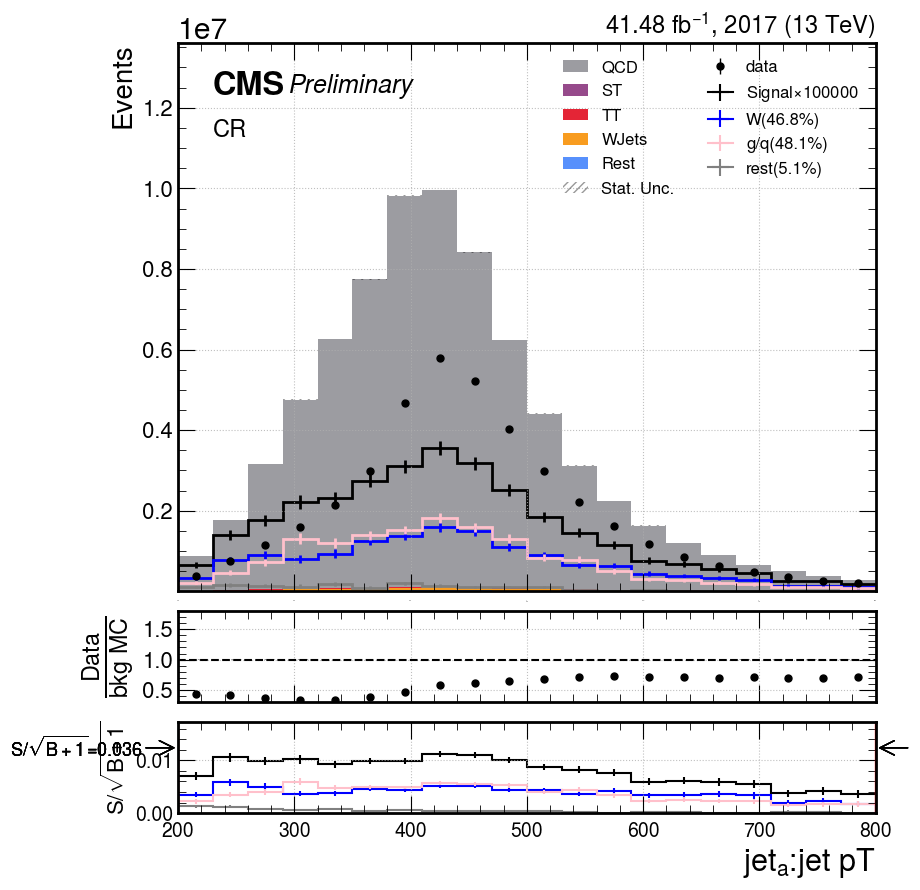

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1926826/3618446447.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1926826/3618446447.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_1926826/3618446447.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 - bkg_err[0]/bkg_h, baseline = 1 + bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_1926

[58063594.15881952  4829493.67374544  2368215.06975771  1505274.98847249
  1083561.08600771   831387.86385982   670667.33415007   556563.09336488
   478122.53829182   415283.95128679   366351.76275269   332210.90563963
   302286.49579696   270354.74931074   250620.08679881   233456.52187706
   216199.86751612   203951.69056511   191117.74683268   179628.25975608
   169311.06004764   163752.13773675   155878.73119896   146418.01372422
   143646.99615847   137811.17192323   130610.41059747   125820.22831006
   123310.24980891   119740.51094755   116865.29317695   114723.80434149
   113195.59732908   110480.41238747   109949.4098601    107556.35758489
        0.                0.                0.                0.        ]
[[21317.20140021  6115.94541006  4285.5161956   3422.96591468
   2909.20422868  2530.75363463  2265.22060359  2064.3265483
   1917.1069441   1785.26199324  1689.87440076  1604.45386921
   1536.42373599  1439.39601262  1397.80373178  1343.39222919
   1299.40636445  1253

/tmp/ipykernel_1926826/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1926826/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1926826/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


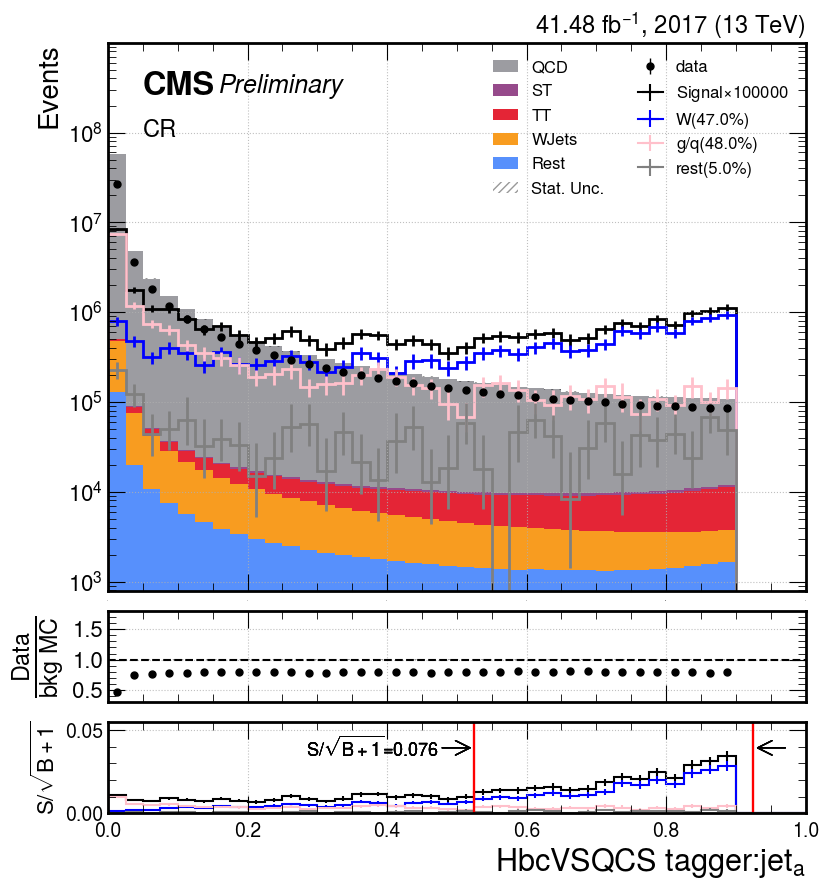

In [13]:
run_makeplots(region = "PS",  blind = False,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR1", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR2", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR3", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "CR",  blind = False,  othertext = "", deco = True) #this set to deco to True